## Ensembles methods

In [ ]:
# !pip install xgboost

In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
dataset = loadtxt('https://gknxt.com/data/pima-indians-diabetes.csv', delimiter=",")

In [3]:
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

In [4]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [5]:
# fit model no training data
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [6]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [7]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.02%


In [8]:
# imports
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [9]:
# load the dataset, returns X and y elements
def load_dataset():
    return make_classification(n_samples=1000, n_classes=2, random_state=1)

In [10]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # linear models
    models['logistic'] = LogisticRegression()
    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alpha:
        models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
    models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
    models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
    # non-linear models
    n_neighbors = range(1, 21)
    for k in n_neighbors:
        models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
    models['cart'] = DecisionTreeClassifier()
    models['extra'] = ExtraTreeClassifier()
    models['svml'] = SVC(kernel='linear')
    models['svmp'] = SVC(kernel='poly')
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr'+str(c)] = SVC(C=c)
    models['bayes'] = GaussianNB()
    # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
    models['bag'] = BaggingClassifier(n_estimators=n_trees)
    models['rf'] = RandomForestClassifier(n_estimators=n_trees)
    models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
    models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models

In [11]:
# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
    # define config ranges
    rates = [0.001, 0.01, 0.1]
    trees = [50, 100]
    ss = [0.5, 0.7, 1.0]
    depth = [3, 7, 9]
    # add configurations
    for l in rates:
        for e in trees:
            for s in ss:
                for d in depth:
                    cfg = [l, e, s, d]
                    if use_xgb:
                        name = 'xgb-' + str(cfg)
                        models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
                    else:
                        name = 'gbm-' + str(cfg)
                        models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
    print('Defined %d models' % len(models))
    return models

In [12]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [13]:
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores


In [14]:
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores

In [15]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = mean(scores), std(scores)
            print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('>%s: error' % name)
    return results


In [16]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    pyplot.boxplot(scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    pyplot.savefig('spotcheck.png')

Defined 53 models
Defined 107 models
>logistic: 0.848 (+/-0.034)
>ridge-0.1: 0.845 (+/-0.038)
>ridge-0.2: 0.845 (+/-0.038)
>ridge-0.3: 0.845 (+/-0.038)
>ridge-0.4: 0.845 (+/-0.038)
>ridge-0.5: 0.845 (+/-0.038)
>ridge-0.6: 0.845 (+/-0.038)
>ridge-0.7: 0.846 (+/-0.039)
>ridge-0.8: 0.847 (+/-0.039)
>ridge-0.9: 0.847 (+/-0.039)
>ridge-1.0: 0.847 (+/-0.039)
>sgd: 0.821 (+/-0.056)
>pa: 0.763 (+/-0.085)
>knn-1: 0.726 (+/-0.040)
>knn-2: 0.688 (+/-0.026)
>knn-3: 0.741 (+/-0.036)
>knn-4: 0.726 (+/-0.027)
>knn-5: 0.768 (+/-0.035)
>knn-6: 0.755 (+/-0.028)
>knn-7: 0.769 (+/-0.038)
>knn-8: 0.761 (+/-0.045)
>knn-9: 0.772 (+/-0.042)
>knn-10: 0.765 (+/-0.040)
>knn-11: 0.781 (+/-0.043)
>knn-12: 0.780 (+/-0.045)
>knn-13: 0.789 (+/-0.036)
>knn-14: 0.788 (+/-0.036)
>knn-15: 0.800 (+/-0.045)
>knn-16: 0.791 (+/-0.039)
>knn-17: 0.799 (+/-0.027)
>knn-18: 0.796 (+/-0.031)
>knn-19: 0.799 (+/-0.033)
>knn-20: 0.801 (+/-0.035)
>cart: 0.802 (+/-0.032)
>extra: 0.738 (+/-0.034)
>svml: 0.841 (+/-0.035)
>svmp: 0.810 (+/

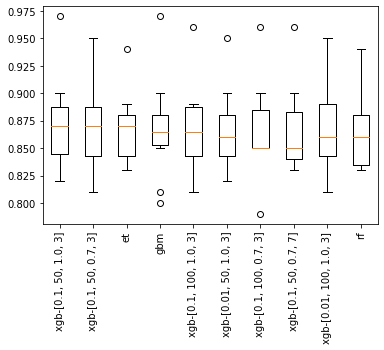

In [17]:
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# add gbm models
models = define_gbm_models(models)
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)